In [1]:
import pandas as pd
import altair as alt
import numpy as np
import scipy.io
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

### Specify the path to the folder that contains the MCA results

In [2]:
base_dir = './'

### Specify the model ID used to generate the MCA file 

Typically the MCA output file is named as `MCA_modelID.mat`

In [3]:
model_id = 'pputida_ccm'

### Specify the number of models in the ensemble

In [4]:
n_models = 10000

### Load the data

In [5]:
file_in_MCA = f'{base_dir}MCA_{model_id}.mat'
file_in_mets = f'{base_dir}{model_id}_metsActive.dat'
file_in_rxns = f'{base_dir}{model_id}_rxnsActive.dat'
file_in_enzs = f'{base_dir}{model_id}_enzNames.dat'

### Get reaction, enzyme, and metabolite names

In [6]:
def get_name_list(file_in):
    
    name_list = []
    with open(file_in, 'r') as f_in:
        line = f_in.readline()
        line = f_in.readline()
        while line:          
            name_list.append(line[2:].strip())
            line = f_in.readline()

    return name_list

rxn_names = get_name_list(file_in_rxns)
enz_names = get_name_list(file_in_enzs)
met_names = get_name_list(file_in_mets)

In [7]:
rxn_names = [i.replace('R_', '').replace('_', ' ') for i in rxn_names]
enz_names = [i.replace('R_', '').replace('_', ' ') for i in enz_names]
met_names = [i.replace('__', '-').replace('m_', '').replace('_c', '').replace('_', ' ') for i in met_names]

### Get control coefficients median and interquartile range

In [8]:
def get_df_median(mat, key_name, id_col, col_names, row_names, n_models):
    
    try:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item())
        df.columns = col_names
    except ValueError:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item()[0])
        df.columns = col_names

    df[id_col] = np.tile(row_names, n_models)
    df_median = df.groupby(id_col).median()
    
    return df_median


def get_df_iqr(mat, key_name, id_col, col_names, row_names, n_models):
    
    try:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item())
        df.columns = col_names
    except ValueError:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item()[0])
        df.columns = col_names

    df[id_col] = np.tile(row_names, n_models)
   
    df_q2 = df.groupby(id_col).quantile(0.25)
    df_q4 = df.groupby(id_col).quantile(0.75)
    
    df_iqr = df_q4.subtract(df_q2)    

    return df_iqr



mat = scipy.io.loadmat(file_in_MCA, squeeze_me=True)

key_name = 'vControl'
id_col = 'rxns'
col_names = rxn_names
row_names = rxn_names
Cv_df_median = get_df_median(mat, key_name, id_col, col_names, row_names, n_models)
Cv_df_iqr = get_df_iqr(mat, key_name, id_col, col_names, row_names, n_models)

key_name = 'xControl'
id_col = 'mets'
col_names = rxn_names
row_names = met_names
Cx_df_median = get_df_median(mat, key_name, id_col, col_names, row_names, n_models)
Cx_df_iqr = get_df_iqr(mat, key_name, id_col, col_names, row_names, n_models)

### Define function to plot heatmaps with altair

In [9]:
def get_heatmaps(C_df_in, id_col,width,height):
    
    C_df = C_df_in
    
    C_df[id_col] = C_df.index
    C_df = C_df.melt(id_vars=[id_col], var_name='variable')
    
    Cx_in = alt.Chart(C_df).mark_rect().encode(
        x='variable:N',
        y=id_col,
        color=alt.Color('value:Q', scale=alt.Scale(scheme='redblue', domain=[1.5,-1.5])),
        tooltip='value:Q'
    ).properties(
        width=width,
        height=height
    )
    

    return Cx_in 

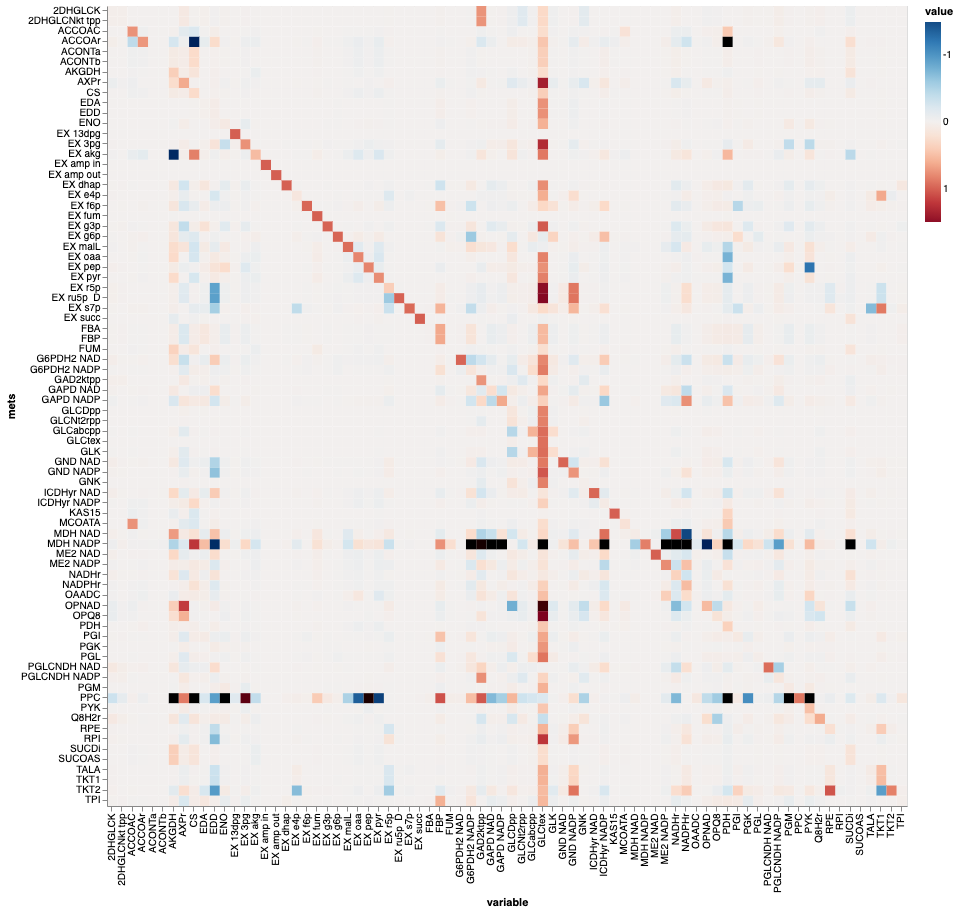

In [14]:
get_heatmaps(Cv_df_median, 'mets', width=800, height=800)

### Plot concentration control coefficients median

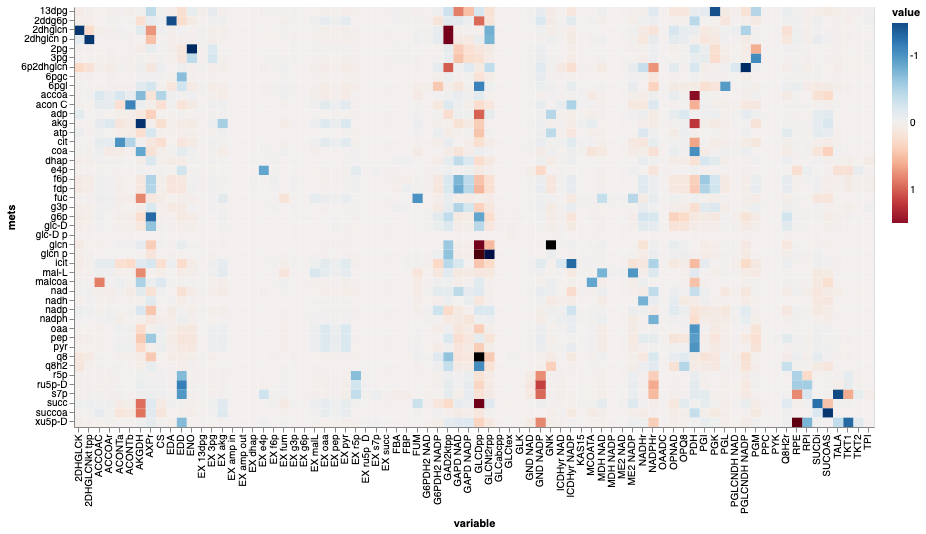

In [18]:
get_heatmaps(Cx_df_median, 'mets', width=800, height=420)

### Plot concentration control coefficients for AcCoa

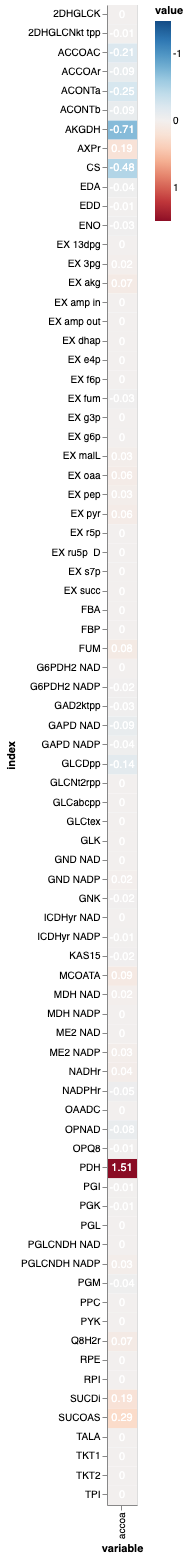

In [20]:
plot_df = Cx_df_median.loc[['accoa']].transpose()
plot_df = plot_df.drop("mets", axis="index")
plot_df = plot_df.reset_index().melt(id_vars="index", var_name="variable")
plot_df["value"] = plot_df["value"].astype("float").round(2)

# get_heatmaps(plot_df, 'mets', width=30, height=1200)

base_chart = alt.Chart(
        plot_df,
        width=30,
        height=1500
    ).encode(
        x="variable:N",
        y="index:N"
    )

heatmap = base_chart.mark_rect().encode(
    color=alt.Color('value:Q', scale=alt.Scale(scheme='redblue', domain=[1.5,-1.5])),
    tooltip='value:Q'
)

numbers = base_chart.mark_text(baseline="middle").encode(
    text="value:Q",
    color=alt.value("white"),
)

heatmap + numbers